<a href="https://colab.research.google.com/github/balawillgetyou/dy/blob/master/FastAiPyTorchULMFiTTextClassifierWhoseLine_wStopWordsRemoval_20200701.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
#!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
#!pip install fastai

In [25]:
# import libraries
import codecs, os, numpy as np, pandas as pd
pd.set_option('display.max_colwidth', None) #to prevent cell display truncation

import re#for text preprocessing (checking for non words)

#metrics calculation
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score

#fastai
import fastai
from fastai import *
from fastai.text import * 
from functools import partial

#stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [27]:
temp = open("/content/gdrive/My Drive/Colab_Notebooks_Bala/WhoseLineIsItAnywayTRAIN.csv", 'r', encoding='latin-1')
WhoseLineData = pd.read_csv(temp)
print('File shape', WhoseLineData.shape, '\n')
print(WhoseLineData.columns, '\n')

File shape (18977, 2) 

Index(['text', 'author'], dtype='object') 



# Data pre-processing:
Simple rebalancing of classes and stop words removal. Minor regex also.

In [28]:
#Ran out of RAM for predictions. Hence dropping out records from some of the more frequent classes. 
WhoseLineData.author.value_counts()

0    3859
5    3517
4    3184
2    2621
3    1314
9    1142
7    1054
8     910
6     755
1     621
Name: author, dtype: int64

In [29]:
df_low=WhoseLineData[WhoseLineData.author.isin([1,6,8,7,9,3])]
df_high=WhoseLineData[~WhoseLineData.author.isin([1,6,8,7,9,3])]
g = df_high.groupby('author')
df_high_trimmed = pd.DataFrame(g.apply(lambda x: x.sample(2000)))
df = pd.concat([df_low,df_high_trimmed])
df = df.reset_index(drop=True)
df = pd.DataFrame({'label':df.author, 'text':df.text})
df.label.value_counts()

5    2000
4    2000
2    2000
0    2000
3    1314
9    1142
7    1054
8     910
6     755
1     621
Name: label, dtype: int64

In [30]:
#Data Preprocessing
#knock out the many white spaces & non words 
df['text'].replace(r'\s+', ' ', regex=True, inplace=True)
df['text'] = df['text'].str.lower().str.replace("[^a-zA-Z]", " ")

#unique word count
uniqueWords = set()
df['text'].str.split().apply(uniqueWords.update)
print('# of unique words',len(uniqueWords))
print('Sample of unique words',list(uniqueWords)[1070:1100])

#number of authors/ classes for the classifier
print("Authors in dataset", sorted(df['label'].unique()))

#to get an idea for the typical length of each text
df['textLength'] = df['text'].str.split().str.len()

#size of writings/ document
display(df.describe())

# tokenization 
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 

df['text'] = detokenized_doc

# of unique words 60038
Sample of unique words ['hibiscus', 'sociability', 'ceremonies', 'innate', 'quixotic', 'games', 'tin', 'fellers', 'ampytated', 'durgin', 'sui', 'politikhae', 'deludes', 'laughin', 'brilliant', 'usefully', 'obsolete', 'entrenchments', 'actions', 'corresponding', 'waitin', 'toughness', 'sticks', 'soon', 'anticipating', 'appoints', 'frugality', 'password', 'brigandine', 'recollects']
Authors in dataset [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


,label,textLength
count,13796.000000,13796.000000
mean,4.061250,418.988402
std,2.751878,325.963616
min,0.000000,24.000000
25%,2.000000,259.000000
50%,4.000000,354.000000
75%,6.000000,490.000000
max,9.000000,5908.000000


In [31]:
# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 35)
df_trn.shape, df_val.shape

((11726, 3), (2070, 3))

# ULMFiT approach:  

1.   General- domain Language Model (embedding for words + documents) pretraining - Wikitext-103. 28,595 preprocessed Wikipedia articles and 103 million words
2.   Target task Language Model fine-tuning - to account for data of the target task being from a different distribution


> Discriminative fine-tuning: Different layers capture different types of information, fine-tuned to different extents, tune each layer with different learning rates

> Slanted triangular learning rates: First linearly increases the learning rate and then linearly decays it, so that model can quickly converge to a suitable region of the parameter space in the beginning
of training and then we refine its parameters

3.   Target task classifier fine-tuning: 2 dense layers with ReLu and Softmax activations. Only these 2 layers are to be trained from scratch. 

> Gradual unfreezing: Fine-tuning all layers at once risks catastrophic forgetting. So, gradually unfreeze the model starting from the last layer as this contains the least general knowledge. Unfreeze one layer and fine-tune all unfrozen layers for one epoch, until convergence at the last iteration.





In [32]:
#data preparation - tokenization and replacement with unique id

# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [33]:
#AWD LSTM is the generic language model
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

In [34]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


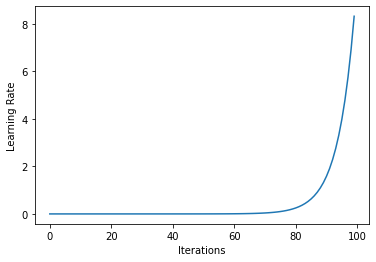

In [35]:
learn.recorder.plot_lr()

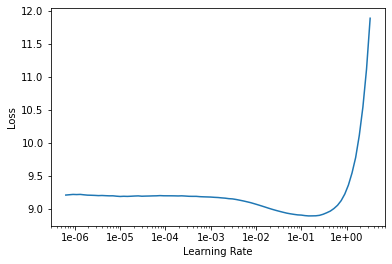

In [36]:
learn.recorder.plot()

In [37]:
# train the learner object with learning rate = 1e-2
learn.fit_one_cycle(1, 1e-2)#fine tuning LM for target task

epoch,train_loss,valid_loss,accuracy,time
0,7.692224,7.459411,0.044750,05:09


In [38]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,7.221128,7.242925,0.051979,05:57


In [39]:
#sample sentence prediction from the fine tuned LM 
learn.predict("giant form towering others caused sudden hush", n_words=10)

'giant form towering others caused sudden hush joy five times since since elegantly transformed thought done made'

In [40]:
learn.save_encoder('ft_enc_whoseLine_small')

In [41]:
#classifier training, using the fine tuned language model from above
#drop_mult controls layers wise drop outs. Setting =1 leaves them at their defaults
learn = text_classifier_learner(data_clas, drop_mult=0.7, arch=AWD_LSTM)
learn.load_encoder('ft_enc_whoseLine_small')
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.654567,0.393270,0.865217,02:59


In [42]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.542967,0.309504,0.897101,03:01


In [43]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.411647,0.262766,0.920290,05:40


In [44]:
learn.save_encoder('txt_classifier_whoseLine_small')

In [57]:
#comparing a few predictions to targets
pd.DataFrame(predictions, targets)[-5:]

,0
4,0
4,6
0,0
0,0
4,4


In [46]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,281,0,0,0,19,11,0,0,0,4
1,0,89,0,0,1,1,0,4,0,1
2,3,0,290,0,0,14,0,4,4,4
3,0,0,0,197,0,2,0,0,0,0
4,7,0,1,0,271,6,0,2,0,0
5,3,1,5,0,2,247,0,6,6,2
6,5,0,0,0,5,4,110,1,0,2
7,0,3,3,0,1,0,2,139,1,3
8,0,0,1,0,0,3,0,0,125,0


In [47]:
precision, recall, fscore, support = score(targets, predictions, labels = [0,1,2,3,4,5,6,7,8,9])
results1 = pd.concat((pd.Series([0,1,2,3,4,5,6,7,8,9]), pd.Series(precision), pd.Series(recall), pd.Series(fscore), pd.Series(support)), axis=1, join = 'outer')
results1.columns=('label','precision', 'recall', 'fscore', 'support')
print('Results','\n','*'*50,'\n',round(results1,2))

Results 
 ************************************************** 
    label  precision  recall  fscore  support
0      0       0.89    0.94    0.91      300
1      1       0.93    0.96    0.94       93
2      2       0.91    0.97    0.94      300
3      3       0.99    1.00    0.99      197
4      4       0.94    0.90    0.92      300
5      5       0.91    0.82    0.86      300
6      6       0.87    0.97    0.92      113
7      7       0.91    0.88    0.90      158
8      8       0.97    0.91    0.94      137
9      9       0.90    0.91    0.90      172
